In [1]:
# import packages

import torch
from collections import OrderedDict

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pgf.texsystem'] = 'pdflatex'
matplotlib.rcParams.update({'font.family': 'serif', 'font.size': 10})
matplotlib.rcParams['text.usetex'] = True
from matplotlib.lines import Line2D

from scipy.interpolate import griddata
from scipy import integrate
import time

np.random.seed(1234)

In this example, we solve a Lotka-Volterra Equation of the general form

\begin{align*}
\frac{dr}{dt} = \alpha r - \beta rp \\
\frac{dp}{dt} = \gamma rp - \delta p
\end{align*}

where $r$ is the number of prey, $p$ is the number of some predator, and $\alpha$, $\beta$, $\gamma$, and $\delta$ are real parameters describing the interactions of the two species. For the sake of simplicity, we assume that these parameters are all equal to one, i.e. we seek to solve the ODE pair

\begin{align*}
\frac{dr}{dt} = r - rp \\
\frac{dp}{dt} = rp - p
\end{align*}

In [3]:
# CUDA support 

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
# define the deep neural network

class DNN(torch.nn.Module):
    
    def __init__(self, layers):
        
        super().__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
    
    
    def forward(self, x):
        
        # x = (t, y0)
        return self.layers(x)

In [6]:
# define the PINN: physics-informed neural network

class PINN():

    def __init__(self, X_pinn, X_semigroup, X_smooth, layers, T):

        # neural network architecture
        self.layers = layers
        self.dnn = DNN(layers).to(device)
        
        # semigroup PINN step time
        self.T = torch.tensor(T).float().to(device)

        # training data
        self.t_pinn = torch.tensor(X_pinn[:, :1], requires_grad=True).float().to(device)
        self.y_pinn = torch.tensor(X_pinn[:, 1:], requires_grad=True).float().to(device)
        
        self.s_semigroup = torch.tensor(X_semigroup[:, :1], requires_grad=True).float().to(device)
        self.t_semigroup = torch.tensor(X_semigroup[:, 1:2], requires_grad=True).float().to(device)
        self.y_semigroup = torch.tensor(X_semigroup[:, 2:], requires_grad=True).float().to(device)
        
        self.t_smooth = torch.tensor(X_smooth[:, :1], requires_grad=True).float().to(device)
        self.y_smooth = torch.tensor(X_smooth[:, 1:], requires_grad=True).float().to(device)
        
        # optimization
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), lr=1.0, max_iter=50000, max_eval=50000, 
            history_size=50, tolerance_grad=1e-5, tolerance_change=np.finfo(float).eps, 
            line_search_fn="strong_wolfe"
        )

        self.iter = 0
    
    
    def net_y(self, t, y0):
        
        # The M(t, y0) = y0 + t N(t, y0) scheme seems to drastically increase the accuracy
        # This works perfectly fine with automatic differentiation
        y = y0 + t * self.dnn(torch.cat([t, y0], dim=1))
        
        return y
    
    
    def net_derivative(self, t, y0):
        """
        Pytorch automatic differentiation to compute the derivative of the neural network
        """
        y = self.net_y(t, y0)
        
        # vectors for the autograd vector Jacobian product 
        # to compute the derivatives w.r.t. every output dimension
        vectors = [torch.zeros_like(y) for i in range(2)]
        
        for i, vec in enumerate(vectors):
            
            vec[:,i] = 1.
        
        # list of derivative tensors
        # the first entry is a tensor with \partial_t PINN(t, y0) for all (t, y0) in the batch,
        # each input (t, y0) corresponds to one row in each tensor
        derivatives = [
            torch.autograd.grad(
                y, t, 
                grad_outputs=vec,
                retain_graph=True,
                create_graph=True
            )[0]
            for vec in vectors
        ]
        
        return derivatives
    
    
    def loss_function(self):
        
        self.optimizer.zero_grad()
        
        y_pred = self.net_y(self.t_pinn, self.y_pinn)
        deriv_pred = self.net_derivative(self.t_pinn, self.y_pinn)
        
        """ This is specific to the Lotka-Volterra system """

        # in our case, dy1/dt = y1 - y1 * y2, dy2/dt = y1 * y2 -y2
        loss_pinn1 = torch.mean((deriv_pred[0] - y_pred[:,0:1] + y_pred[:,0:1] * y_pred[:,1:2]) ** 2)
        loss_pinn2 = torch.mean((deriv_pred[1] - y_pred[:,0:1] * y_pred[:,1:2] + y_pred[:,1:2]) ** 2)
        loss_pinn = loss_pinn1 + loss_pinn2 
        
        # The general semigroup loss for autonomous ODEs
        y_pred_tps = self.net_y(self.s_semigroup + self.t_semigroup, self.y_semigroup)
        y_pred_s = self.net_y(self.s_semigroup, self.y_semigroup)
        y_pred_restart = self.net_y(self.t_semigroup, y_pred_s)
        loss_semigroup = torch.mean((y_pred_tps - y_pred_restart) ** 2)
        
        # The smoothness loss
        y_pred_smooth = self.net_y(self.t_smooth, self.y_smooth)
        deriv_pred_below = self.net_derivative(self.t_smooth, self.y_smooth)
        deriv_pred_above = self.net_derivative(torch.zeros_like(self.t_smooth, requires_grad=True), y_pred_smooth)
        
        loss_smooth = .0
        
        for t1, t2 in zip(deriv_pred_below, deriv_pred_above):
            
            loss_smooth += torch.mean((t1 - t2) ** 2)
        
        loss = loss_pinn + loss_smooth + loss_semigroup
        
        loss.backward()
        self.iter += 1
        
        if self.iter % 100 == 0:
            print(
                f"Iter {self.iter}, Loss: {loss.item():.5f}, Loss_pinn: {loss_pinn.item():.5f} " \
                f"Loss_smooth: {loss_smooth.item():.5f}, Loss_semigroup: {loss_semigroup.item():.5f}"
            )
        
        return loss
    
    
    def train(self):
        
        self.dnn.train()
        self.optimizer.step(self.loss_function)
    
    
    def predict(self, t, y0):
        
        t = torch.tensor(t, requires_grad=True).float().to(device)
        y0 = torch.tensor(y0, requires_grad=True).float().to(device)
        
        self.dnn.eval()
        y = self.net_y(t, y0)
        y = y.detach().cpu().numpy()
        
        return y

### Setup data example

In [7]:
""" Use a DNN with 6 hidden layers and 64 neurons per layer for Lotka-Volterra """

layers = [3, 64, 64, 64, 64, 64, 64, 2]

T = 1
max_y0 = 5

# standard PINN loss function training samples
N_pinn = 10000
N_semigroup = 10000
N_smooth = 10000


t_pinn = np.random.uniform(0, T, (N_pinn, 1))
y_pinn = np.random.uniform(0, max_y0, (N_pinn, 2))
X_pinn = np.hstack([t_pinn, y_pinn])


r1 = np.random.uniform(0, 1, N_semigroup)
r2 = np.random.uniform(0, 1, N_semigroup)
s_semigroup, t_semigroup = np.sqrt(r1) * (1 - r2), r2 * np.sqrt(r1)
s_semigroup, t_semigroup = T * s_semigroup[:, np.newaxis], T * t_semigroup[:, np.newaxis]
y_semigroup = np.random.uniform(0, max_y0, (N_semigroup, 2))
X_semigroup = np.hstack([s_semigroup, t_semigroup, y_semigroup])


t_smooth = np.random.uniform(0, T, (N_smooth, 1))
y_smooth = np.random.uniform(0, max_y0, (N_smooth, 2))
X_smooth = np.hstack([t_smooth, y_smooth])

In [8]:
# initialize the PINN

model = PINN(X_pinn, X_semigroup, X_smooth, layers, T)

In [ ]:
# train the model from scratch or load an already trained model (next cell)

%%time
               
model.train()

Iter 100, Loss: 2.08969, Loss_pinn: 1.55702 Loss_smooth: 0.52233, Loss_semigroup: 0.01035
Iter 200, Loss: 0.39984, Loss_pinn: 0.25900 Loss_smooth: 0.13734, Loss_semigroup: 0.00350
Iter 300, Loss: 0.14981, Loss_pinn: 0.09611 Loss_smooth: 0.05281, Loss_semigroup: 0.00089
Iter 400, Loss: 0.08359, Loss_pinn: 0.05276 Loss_smooth: 0.02986, Loss_semigroup: 0.00097
Iter 500, Loss: 0.04439, Loss_pinn: 0.02867 Loss_smooth: 0.01519, Loss_semigroup: 0.00054
Iter 600, Loss: 0.02971, Loss_pinn: 0.01980 Loss_smooth: 0.00962, Loss_semigroup: 0.00028
Iter 700, Loss: 0.02030, Loss_pinn: 0.01354 Loss_smooth: 0.00640, Loss_semigroup: 0.00037
Iter 800, Loss: 0.01506, Loss_pinn: 0.00975 Loss_smooth: 0.00508, Loss_semigroup: 0.00023
Iter 900, Loss: 0.01163, Loss_pinn: 0.00754 Loss_smooth: 0.00391, Loss_semigroup: 0.00018
Iter 1000, Loss: 0.00916, Loss_pinn: 0.00581 Loss_smooth: 0.00315, Loss_semigroup: 0.00020
Iter 1100, Loss: 0.00685, Loss_pinn: 0.00424 Loss_smooth: 0.00249, Loss_semigroup: 0.00012
Iter 120

In [ ]:
# save the model

import os

path = os.getcwd()

torch.save(model.dnn.state_dict(), path + '/model_new.pt')

In [19]:
# load an already existing model

path = '/content/drive/MyDrive/CS 242 - Computing at Scale'

model.dnn.load_state_dict(torch.load(path + '/model_new.pt'))

# print(model.dnn.state_dict())

<All keys matched successfully>

## Predict and Plot the Solution

In [11]:
# visualization functions for simple ODEs, we don't use this for Lotka-Volterra

def generate_figure(figsize, xlim, ylim):
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.spines[['top', 'right']].set_visible(False)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    return fig, ax


def plot_ode_solution(ax, y, *args, **kwargs):
    
    ax.plot(y[:,0], y[:,1], '.-', *args, **kwargs)
    
    return ax

In [12]:
# predict the solution of the Lotka-Volterra ODE

def predict_standard(model, y0, max_t_pred, delta_t):
    
    times = np.linspace(0, max_t_pred, int(max_t_pred / delta_t) + 1)
    times = times[:,np.newaxis]
    
    y0 = np.array([y0 for _ in range(len(times))])
    trajectory =  model.predict(times, y0)
    
    return trajectory


def predict_dac(model, y0, max_t_pred, delta_t):
    """
    detla_t should devide model.max_t to guarantee equidistant steps
    """
    times = np.arange(0, model.T + delta_t, delta_t)[1:]
    times = times[:,np.newaxis]
    n_resets = int(np.ceil(max_t_pred / model.T))
    
    trajectory = np.array([y0])
    
    for _ in range(n_resets):
        
        y0 = trajectory[-1]
        y0 = np.array([y0 for _ in range(len(times))])
        segment =  model.predict(times, y0)
        trajectory = np.vstack([trajectory, segment])
    
    return trajectory

In [20]:
# Compute the solution for a given initial condition
# Note that max_t in training is 1

y0 = [0.15, 1]
max_t_pred = 40
delta_t = 0.05

validation_dac = predict_dac(model, y0, max_t_pred, delta_t)
validation_standard = predict_standard(model, y0, max_t_pred, delta_t)

In [21]:
# compute true solution using scipy.integrate.solve_ivp

def func(t, r):
    x, y = r
    dx_t = x - x * y
    dy_t = x * y - y
    return dx_t, dy_t


def gen_truedata():
    t = np.linspace(0, max_t_pred, int(max_t_pred / delta_t) + 1)

    sol = integrate.solve_ivp(func, (0, 40), (y0[0], y0[1]), t_eval=t) 
    x_true, y_true = sol.y

    return np.stack((x_true, y_true), axis = 1)


true_solution = gen_truedata()

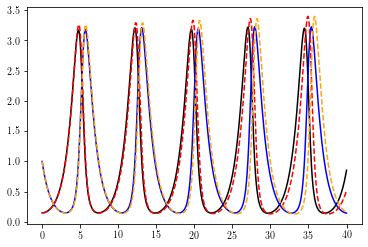

In [22]:
# plot the results and compare with the true solution

#plt.xlabel("t")
#plt.ylabel("population")

t = np.linspace(0, 40, 801)
x_true = true_solution[:, 0]
y_true = true_solution[:, 1]
plt.plot(t, x_true, color="black")
plt.plot(t, y_true, color="blue")


x_pred = validation_dac[:, 0]
y_pred = validation_dac[:, 1]

plt.plot(t, x_pred, color="red", linestyle="dashed")
plt.plot(t, y_pred, color="orange", linestyle="dashed")
# plt.legend()
plt.show()

In [16]:
# might have to install these packages for visualization purposes before running the previous cell

! sudo apt-get install texlive-latex-recommended 
! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended  
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip 
! unzip type1cm.zip -d /tmp/type1cm 
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
! sudo mkdir /usr/share/texmf/tex/latex/type1cm 
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm 
! sudo texhash 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-droid-fallback fonts-lmodern fonts-noto-mono libcupsfilters1
  libcupsimage2 libgs9 libgs9-common libijs-0.35 libjbig2dec0 libkpathsea6
  libpotrace0 libptexenc1 libsynctex1 libtexlua52 libtexluajit2 libzzip-0-13
  lmodern poppler-data t1utils tex-common texlive-base texlive-binaries
  texlive-latex-base
Suggested packages:
  fonts-noto poppler-utils ghostscript fonts-japanese-mincho
  | fonts-ipafont-mincho fonts-japanese-gothic | fonts-ipafont-gothic
  fonts-arphic-ukai fonts-arphic-uming fonts-nanum debhelper gv
  | postscript-viewer perl-tk xpdf-reader | pdf-viewer texlive-latex-base-doc
  texlive-latex-recommended-doc texlive-pstricks
The following NEW packages will be installed:
  fonts-d

In [17]:
!apt install cm-super

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  cm-super-minimal pfb2t1c2pfb
The following NEW packages will be installed:
  cm-super cm-super-minimal pfb2t1c2pfb
0 upgraded, 3 newly installed, 0 to remove and 20 not upgraded.
Need to get 24.5 MB of archives.
After this operation, 59.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 cm-super-minimal all 0.3.4-11 [5,810 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 pfb2t1c2pfb amd64 0.3-11 [9,342 B]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 cm-super all 0.3.4-11 [18.7 MB]
Fetched 24.5 MB in 3s (9,552 kB/s)
Selecting previously unselected package cm-super-minimal.
(Reading database ... 149894 files and directorie